In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings

plt.style.use('default')
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

Loading BokehJS ...

## Acoustic features

## Prosodic features
using praat

In [2]:
# combine 5 sentences into 1
sample_sentence = """
Good morning, It's nice to see you around. Please, go ahead. I wouldn't want to hold you up. That's very kind of you, I appreciate it. Have a nice day! 
Hi there! If you're in a hurry, please go ahead. That's very kind of you, thank you!
Hi there! How's your day going? Oh, are you going that way? Please keep going. Hey, thanks a bunch for letting me go ahead!
Hi, Have a wonderful day! Hey there! No need to stand on ceremony, go right ahead. Thank you! Your help brightened my day.
Hello. Please go ahead. Thank you.
"""
sentence_list = {
    "ARG": "Good morning, It's nice to see you around. Please, go ahead. I wouldn't want to hold you up. That's very kind of you, I appreciate it. Have a nice day!",
    "CON": "Hi there! If you're in a hurry, please go ahead. That's very kind of you, thank you!",
    "OPN": "Hi there! How's your day going? Oh, are you going that way? Please keep going. Hey, thanks a bunch for letting me go ahead!",
    "EXT": "Hi, Have a wonderful day! Hey there! No need to stand on ceremony, go right ahead. Thank you! Your help brightened my day",
    "NEU": "Hello. Please go ahead. Thank you",
    "Combined": sample_sentence,
}


In [3]:
import pandas as pd
import parselmouth

from utils.praat_feature_extraction import *

def praat_feats_extract(sound_filepath, feats=['intensity', 'pitch', 'hnr', 'gne', 'local_jitter', 'local_shimmer', 'spectrum', 'formant', 'lfcc', 'mfcc', 'delta_mfcc', 'delta_delta_mfcc'], sentence=''):

    sound = parselmouth.Sound(sound_filepath)
    attributes = {}

    if 'intensity' in feats:
        intensity_attributes = get_intensity_attributes(sound, return_values=True)[0]
        attributes.update(intensity_attributes)
    if 'pitch' in feats:
        pitch_attributes = get_pitch_attributes(sound, return_values=True)[0]
        attributes.update(pitch_attributes)
    if 'hnr' in feats:
        hnr_attributes = get_harmonics_to_noise_ratio_attributes(sound)[0]
        attributes.update(hnr_attributes)
    if 'gne' in feats:
        gne_attributes = get_glottal_to_noise_ratio_attributes(sound)[0]
        attributes.update(gne_attributes)
    if 'local_jitter' in feats:
        attributes['local_jitter'] = get_local_jitter(sound)
    if 'local_shimmer' in feats:
        attributes['local_shimmer'] = get_local_shimmer(sound)
    if 'spectrum' in feats:
        spectrum_attributes = get_spectrum_attributes(sound)[0]
        attributes.update(spectrum_attributes)
    if 'formant' in feats:
        formant_attributes = get_formant_attributes(sound, window_length=0.04)[0]
        attributes.update(formant_attributes)
    if 'lfcc' in feats:
        lfcc_matrix = get_lfcc(sound)
        attributes['lfcc'] = lfcc_matrix
    if 'mfcc' in feats:
        mfcc_matrix = get_mfcc(sound)
        attributes['mfcc'] = mfcc_matrix
    if 'delta_mfcc' in feats:
        delta_mfcc_matrix = get_delta(mfcc_matrix)
        attributes['delta_mfcc'] = delta_mfcc_matrix
    if 'delta_delta_mfcc' in feats:
        delta_delta_mfcc_matrix = get_delta(delta_mfcc_matrix)
        attributes['delta_delta_mfcc'] = delta_delta_mfcc_matrix
    
    if 'speaking_rate' in feats:
        attributes['speaking_rate'] = get_speaking_rate(sound, sentence)
    
    if 'voiced_unvoiced' in feats:
        voiced_unvoiced = get_voiced_unvoiced_segments(sound)[0]
        attributes.update(voiced_unvoiced)
    
    if 'energy' in feats:
        energy = get_energy(sound)[0]
        attributes.update(energy)

    return attributes

praat_feats_extract('./generated/characters_wav_files_44100Hz/generated/0/en-AU-AnnetteNeural/en-AU-AnnetteNeural-CON.wav', feats=['intensity', 'pitch', 'formant', 'speaking_rate', 'voiced_unvoiced', 'energy'], sentence=sentence_list['CON'])

{'min_intensity': -332.12887185386035,
 'relative_min_intensity_time': 0.5302750728169144,
 'max_intensity': 82.6790183837564,
 'relative_max_intensity_time': 0.2632209970118534,
 'mean_intensity': -32.58932610761897,
 'stddev_intensity': 155.4622263868757,
 'q1_intensity': -42.57568647798015,
 'median_intensity': 219.69458433323874,
 'q3_intensity': 76.68883953107418,
 'entropy_intensity': 0.8437537462390333,
 'voiced_fraction': 0.43103448275862066,
 'min_pitch': 166.09108454579112,
 'relative_min_pitch_time': 0.08684371751360304,
 'max_pitch': 311.3669155915833,
 'relative_max_pitch_time': 0.40739980307201085,
 'mean_pitch': 220.83594642549727,
 'stddev_pitch': 31.753763683099432,
 'q1_pitch': 195.62262598065413,
 'q3_pitch': 241.96568985700247,
 'mean_absolute_pitch_slope': 253.431280766427,
 'pitch_slope_without_octave_jumps': 19.45166387749576,
 'entropy_pitch': 0.5489353253648812,
 'f1_mean': 552.3003917437231,
 'f2_mean': 2007.362705349098,
 'f3_mean': 2909.595481516411,
 'f4_me

In [10]:
from tqdm import tqdm
df = pd.read_excel('./logs/big5/data_all.xlsx')
# extract praat features for each audio file in the dataset and export to a new excel file
# Accent	Content	Name	Gender	Path	Extraversion	Agreeableness	Conscientiousness	Neuroticism	Openness
df = df[df["Content"] != "Combined"]

praat_feats = []
for i, row in tqdm(list(df.iterrows())):
    try:
        sentence = sentence_list[row['Content']]
        praat_feats.append(praat_feats_extract(row['Path'], feats=['intensity', 'pitch', 'formant', 'speaking_rate', 'voiced_unvoiced', 'energy'], sentence=sentence))
    except Exception as e:
        print(f"Error: {e}")
        praat_feats.append({})
        continue
    
praat_feats_df = pd.DataFrame(praat_feats)
praat_feats_df['Path'] = df['Path']

100%|██████████| 850/850 [12:21<00:00,  1.15it/s]


In [11]:
praat_feats_df['Path'] = df['Path']

In [12]:
# merge the extracted praat features with the original dataset

df = df.merge(praat_feats_df, on="Path")
df.head()

,Accent,Content,Name,Gender,Path,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,...,unvoice_length_min,unvoice_length_max,voice_length_entropy,unvoice_length_entropy,speech_ratio,min_energy,max_energy,mean_energy,stddev_energy,entropy_energy
0,AU,ARG,AnnetteNeural,Female,generated\characters_wav_files_44100Hz\generat...,0.42102,0.53003,0.51036,0.53833,0.49649,...,0.064,1.072,1.0,1.0,0.537624,0.003618,0.027535,0.015218,0.007538,1.0
1,AU,ARG,AnnetteNeural,Female,generated\characters_wav_files_44100Hz\generat...,0.42102,0.53003,0.51036,0.53833,0.49649,...,0.064,1.072,1.0,1.0,0.537624,0.003618,0.027535,0.015218,0.007538,1.0
2,AU,ARG,CarlyNeural,Female,generated\characters_wav_files_44100Hz\generat...,0.45562,0.52936,0.49175,0.52675,0.51970,...,0.064,1.104,1.0,1.0,0.542231,0.001634,0.020889,0.009672,0.005876,1.0
3,AU,ARG,CarlyNeural,Female,generated\characters_wav_files_44100Hz\generat...,0.45562,0.52936,0.49175,0.52675,0.51970,...,0.064,1.104,1.0,1.0,0.542231,0.001634,0.020889,0.009672,0.005876,1.0
4,AU,ARG,ElsieNeural,Female,generated\characters_wav_files_44100Hz\generat...,0.43067,0.55428,0.47606,0.53384,0.49665,...,0.056,1.088,1.0,1.0,0.534487,0.002485,0.025609,0.010432,0.006840,1.0


In [13]:
df.to_excel('./logs/big5/data_all_praat_feats.xlsx', index=False)

In [14]:
df.columns

Index(['Accent', 'Content', 'Name', 'Gender', 'Path', 'Extraversion',
       'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness',
       'EXT_label', 'AGR_label', 'CON_label', 'NEU_label', 'OPN_label',
       'min_intensity', 'relative_min_intensity_time', 'max_intensity',
       'relative_max_intensity_time', 'mean_intensity', 'stddev_intensity',
       'q1_intensity', 'median_intensity', 'q3_intensity', 'entropy_intensity',
       'voiced_fraction', 'min_pitch', 'relative_min_pitch_time', 'max_pitch',
       'relative_max_pitch_time', 'mean_pitch', 'stddev_pitch', 'q1_pitch',
       'q3_pitch', 'mean_absolute_pitch_slope',
       'pitch_slope_without_octave_jumps', 'entropy_pitch', 'f1_mean',
       'f2_mean', 'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'f1_max', 'f2_max', 'f3_max', 'f4_max', 'f1_min', 'f2_min',
       'f3_min', 'f4_min', 'f1_entropy', 'f2_entropy', 'f3_entropy',
       'f4_entropy', 'formant_dispersion', 'average_form

In [27]:
# original dataframe header:
# Accent	Content	Name	Gender	Path	Extraversion	Agreeableness	Conscientiousness	Neuroticism	Openness	EXT_label	AGR_label	CON_label	NEU_label	OPN_label
# praat_feats_df will be merged with the original dataframe

# do logistic regression on the praat features to predict the big5 personality traits (EXT_label, AGR_label, CON_label, NEU_label, OPN_label)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df[['min_pitch', 'max_pitch', 'mean_pitch', 'entropy_pitch', 
        'f1_min', 'f1_max', 'f1_mean', 'f1_entropy',
        'f2_min', 'f2_max', 'f2_mean',  'f2_entropy', 
        'voice_length_mean', 'unvoice_length_mean', 
        'voice_length_min', 'voice_length_max', 
        'unvoice_length_min', 'unvoice_length_max',
        'voice_length_entropy', 'unvoice_length_entropy',
        'min_energy', 'max_energy' ,'mean_energy', 'entropy_energy',]]

  

ARG model accuracy: 0.638235294117647
ARG model coefficients: [[-1.00776418e-02  4.08668790e-03 -1.82372775e-02  1.07287583e+00
  -7.50352267e-04 -1.50603052e-04  8.89753655e-03 -6.65260798e-02
  -4.28399140e-04  3.18695372e-04  1.94877393e-04 -6.65260798e-02
  -6.40335562e-01 -2.21946401e+00 -1.19753040e+00 -9.80888120e-02
  -2.04223757e-01 -5.01301667e-01 -1.15071871e-01 -1.61934620e-01
  -2.79728662e-02 -8.23044116e-03 -2.02254995e-02 -6.65260798e-02]]


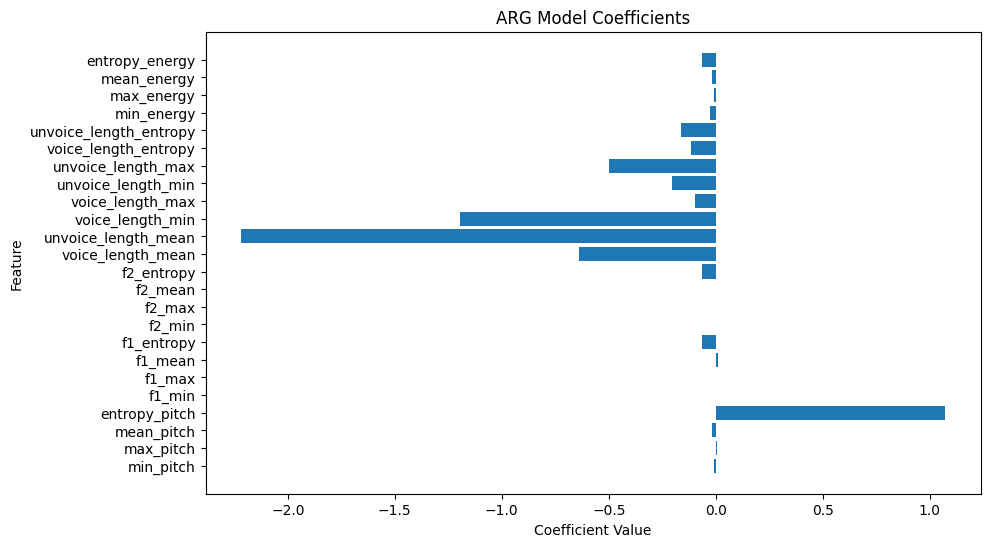

In [28]:
# ARG model
y = df[['AGR_label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(f"ARG model accuracy: {logisticRegr.score(X_test, y_test)}")
# plot model coefficients
print(f"ARG model coefficients: {logisticRegr.coef_}")
plt.figure(figsize=(10, 6))
plt.barh(X.columns, logisticRegr.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('ARG Model Coefficients')
plt.show()

EXT model accuracy: 0.7058823529411765
EXT model coefficients: [[-1.46799600e-02  3.42681010e-03  1.47315506e-02  5.77197706e-01
   1.62531837e-03 -2.25550241e-04  8.88639076e-03 -6.32974887e-01
   1.56030807e-04 -9.90851823e-04 -6.23897409e-04 -6.32974887e-01
   5.60461664e-02 -9.84578791e-01 -5.72550924e-01 -1.88291735e-01
  -6.06522793e-04  1.68409291e+00 -6.50005643e-01 -8.10669107e-01
  -3.80418467e-02 -1.57963098e-01 -7.30121391e-02 -6.32974887e-01]]


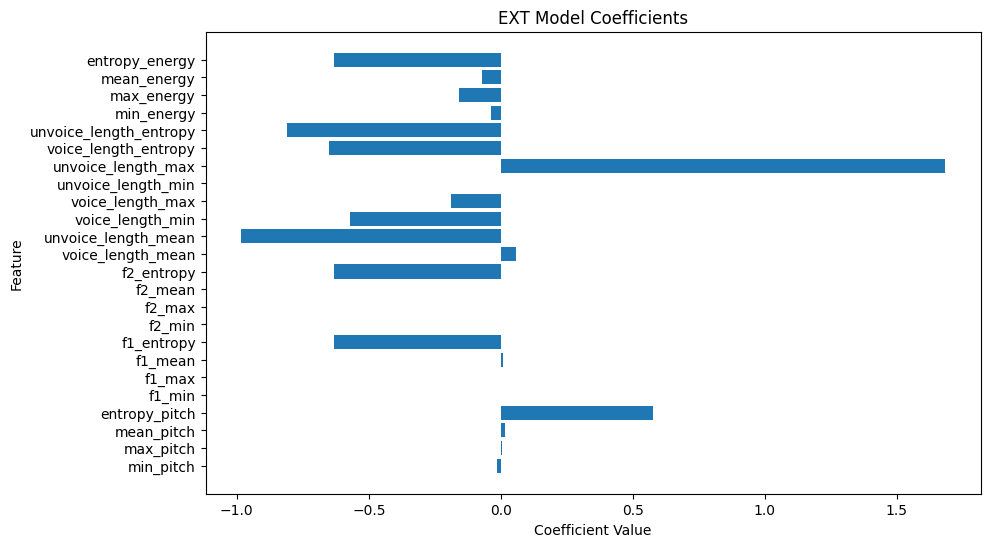

In [29]:
# EXT model
y = df[['EXT_label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(f"EXT model accuracy: {logisticRegr.score(X_test, y_test)}")
# plot model coefficients
print(f"EXT model coefficients: {logisticRegr.coef_}")
plt.figure(figsize=(10, 6))
plt.barh(X.columns, logisticRegr.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('EXT Model Coefficients')
plt.show()

CON model accuracy: 0.5970588235294118
CON model coefficients: [[ 1.22998652e-03  2.42477580e-03 -1.34129516e-02  1.20469295e+00
   1.55017391e-03  1.47840293e-04  1.95469027e-03 -3.26157706e-02
   4.32635870e-04 -6.05442055e-04  2.13513603e-03 -3.26157706e-02
  -1.55032756e+00 -1.66928965e+00 -7.43949575e-01 -2.28254463e-01
  -5.35414973e-01 -1.09183928e-01 -1.23472314e-01 -2.86822905e-01
  -8.02825399e-03  8.26230541e-02  6.25309804e-03 -3.26157706e-02]]


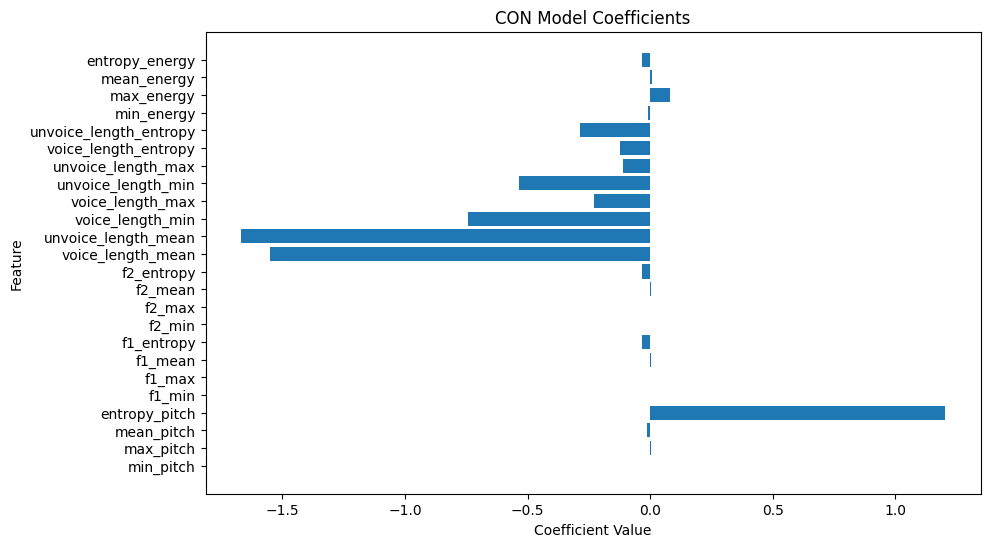

In [30]:
# CON model
y = df[['CON_label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(f"CON model accuracy: {logisticRegr.score(X_test, y_test)}")
# plot model coefficients
print(f"CON model coefficients: {logisticRegr.coef_}")
plt.figure(figsize=(10, 6))
plt.barh(X.columns, logisticRegr.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('CON Model Coefficients')
plt.show()

NEU model accuracy: 0.6088235294117647
NEU model coefficients: [[ 9.12756500e-03 -4.29244901e-03  1.22529360e-02 -1.35344471e+00
  -1.79821049e-04  2.35858855e-04 -1.06014660e-02  1.60513798e-01
  -2.47146120e-04  9.34674349e-04 -2.59417113e-04  1.60513798e-01
   7.51473971e-01  1.76661496e+00  5.79344292e-01 -4.38155343e-02
   2.65504135e-01 -7.66303412e-01  1.96608958e-01  3.48051516e-01
   1.83956059e-02 -2.73873884e-02 -2.45671621e-03  1.60513798e-01]]


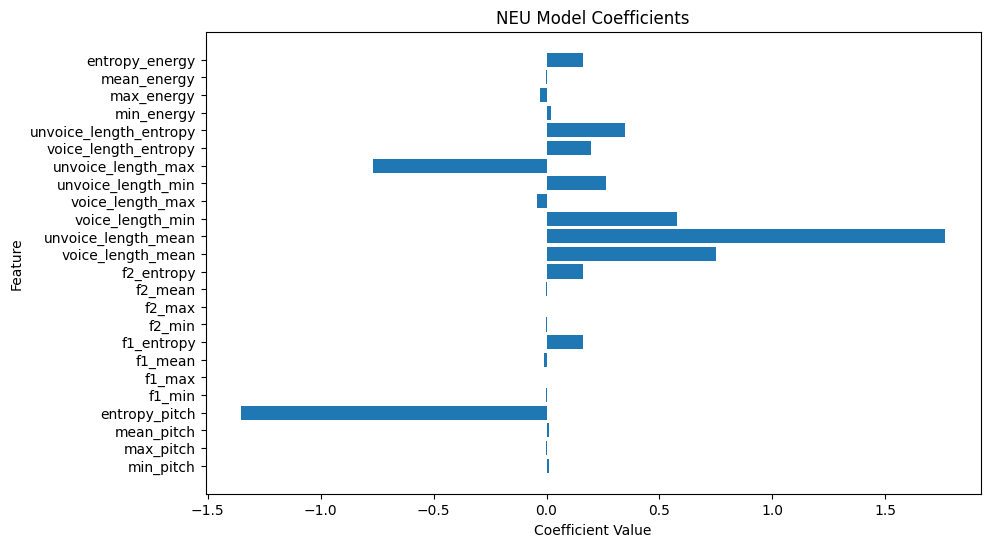

In [31]:
# NEU model
y = df[['NEU_label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(f"NEU model accuracy: {logisticRegr.score(X_test, y_test)}")
# plot model coefficients
print(f"NEU model coefficients: {logisticRegr.coef_}")
plt.figure(figsize=(10, 6))
plt.barh(X.columns, logisticRegr.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('NEU Model Coefficients')
plt.show()

OPN model accuracy: 0.6735294117647059
OPN model coefficients: [[-1.13177920e-02  3.56750350e-03  1.68971965e-02  2.11139915e-01
   4.87746363e-03  2.17155363e-04  7.94667925e-03 -6.45557385e-01
   4.27153593e-05 -7.24042265e-04 -1.43085712e-03 -6.45557385e-01
  -6.85223157e-01 -2.87918781e-01 -4.78769113e-01 -4.20358714e-01
   1.78074950e-01  1.39056440e+00 -6.66607309e-01 -7.85285478e-01
  -3.29615379e-02 -1.46690580e-01 -6.39637401e-02 -6.45557385e-01]]


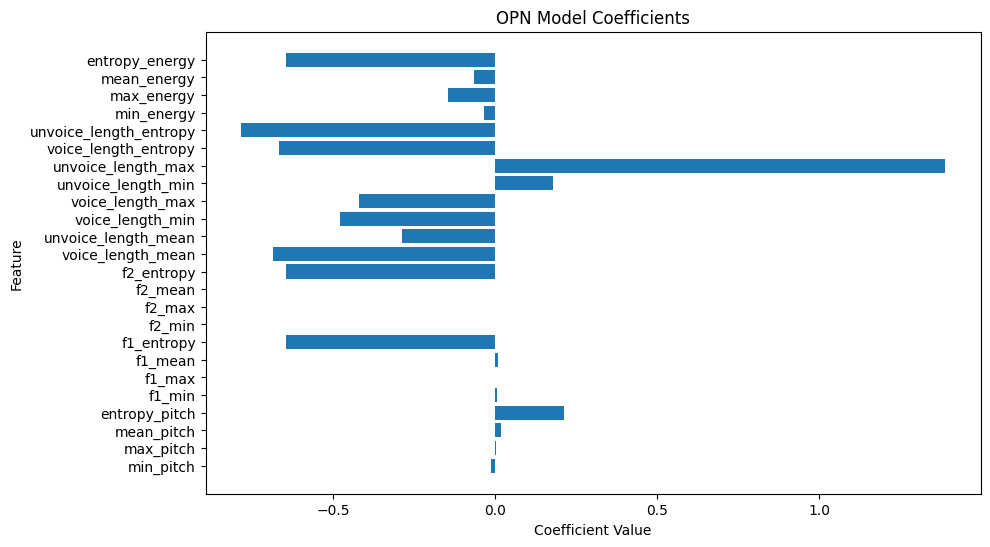

In [32]:
# OPN model
y = df[['OPN_label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(f"OPN model accuracy: {logisticRegr.score(X_test, y_test)}")
# plot model coefficients
print(f"OPN model coefficients: {logisticRegr.coef_}")
plt.figure(figsize=(10, 6))
plt.barh(X.columns, logisticRegr.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('OPN Model Coefficients')
plt.show()